In [1]:
import pandas as pd
import numpy as np
import sqlite3
import zipfile
import ast
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm

## **List of Dataframes**:

* Here we have read in the (5) dataframes provided in the zippedData folder. These data files consist of Movie Info, Movie Gross Info, Movie Budget Info, Movie Reviews & tmbd info.
* We have also printed the columns from each dataframe to visualize their columns.
* regarding columns, we have decided to drop columns from (2) of the Dataframes:
    * **Movie_info_df**: We decided to drop ['box_office', 'currency', 'dvd_date', 'studio'] due to a lack of data.
    * **Movie_reviews_df**: We decided to drop rating due to poor initial formatting & lack of data.

In [2]:
# Dataframes
movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t', compression='gzip')
movie_info_drop = ['box_office', 'currency', 'dvd_date', 'studio']
movie_info_df = movie_info_df.drop(columns=movie_info_drop)
print(f'movie_info_df columns: \n{list(movie_info_df.columns)}\n')


movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
print(f'movie_gross_df columns: \n{list(movie_gross_df.columns)}\n')

movie_budget_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
print(f'movie_budget_df columns: \n{list(movie_budget_df.columns)}\n')

movie_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', compression='gzip', encoding='latin-1')
movie_review_drop = ['rating']
movie_reviews_df = movie_reviews_df.drop(columns=movie_review_drop) # Dropping rating: poor formatting & lacking 50% of data.
print(f'movie_reviews_df columns: \n{list(movie_reviews_df.columns)}\n')


tmbd_movie_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
print(f'tmbd_movie_df columns: \n{list(tmbd_movie_df.columns)}\n')

movie_info_df columns: 
['id', 'synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'runtime']

movie_gross_df columns: 
['title', 'studio', 'domestic_gross', 'foreign_gross', 'year']

movie_budget_df columns: 
['id', 'release_date', 'movie', 'production_budget', 'domestic_gross', 'worldwide_gross']

movie_reviews_df columns: 
['id', 'review', 'fresh', 'critic', 'top_critic', 'publisher', 'date']

tmbd_movie_df columns: 
['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title', 'popularity', 'release_date', 'title', 'vote_average', 'vote_count']



**Combined Datraframe**: MAIN_DF

* After reviewing every column in each dataframe, we found we could combine multiple dataframes.
* We will be using to (3) of the above dataframes to create our **Main_DF** are:
    1. tmbd_movie_df
    2. movie_gross_df
    3. movie_budget_df
    * **We will not be using (movie_info_df & movie_reviews_df in this main dataframe)**
* These dataframes were **joined on the 'title'** column. 
* In movie_budget_df, the title column was named 'movie' so before merging, we needed to change the name of that column to **standardize it to 'title'**
* Once this master dataframe was joined, we needed to **drop duplicate columns** with a majority of missing columns.
* Once we had the correct columns the final step was to **rename columns** to better reflect what their data represented.

In [3]:
#change budget column name to title instead of movie
movie_budget_df = movie_budget_df.rename(columns={'movie': 'title'})
# Merge tmbd_movie_df and movie_gross_df]
main_df = pd.merge(tmbd_movie_df, movie_gross_df, on='title', how='left')
# Keep only the 'title' and 'production_budget' columns from movie_budget_df
main_budget_df = movie_budget_df[['title', 'production_budget']]
# Merge master_df and movie_budget_df
main_df = pd.merge(main_df, movie_budget_df, on='title', how='left')
# Drop unused column
column_to_drop = ['Unnamed: 0', 'release_date_y', 'domestic_gross_y', 'id_y', 'year']
main_df = main_df.drop(columns=column_to_drop)
#rename main_df columns to better reflact data
main_df = main_df.rename(columns={'id_x': 'id', 'release_date_x': 'release_date', 'domestic_gross_x': 'domestic_gross'})


Cleaning & filtering **MAIN_DF**:

* Since the columns have been established and renamed above, we are ready to clean and filter the data.
* We filter to en (english) movies only.
* We also refined the data to movies between 2010 and 2019. 
    * (2019 is the latest entry of the data)
* To perform calculations on production_budget & worldwide_gross we needed to strip the commas and dollar signs.
    * We also filled any missing values with 0
* After cleaning the gross and budget data, we could create a new column called 'ROI' to show the performance of a movie.
* We also needed to decode the genres from their number to their name. 
    * To do this we create a dictionary to convert the number.
    * we then created a function to create a new row with all the respective genres.

In [4]:
# Filter to only english
main_df = main_df[main_df['original_language'] == 'en']
# Filter by 2010 and sooner
main_df = main_df[main_df['release_date'] >= '2010-01-01']
#Updateing 'production_budget' & 'worldwide_gross' columns
# First, replace $ and ,
main_df['production_budget'] = main_df['production_budget'].str.replace('$', '').str.replace(',', '')
main_df['worldwide_gross'] = main_df['worldwide_gross'].str.replace('$', '').str.replace(',', '')
# Fill NaNs with 0
main_df['production_budget'] = main_df['production_budget'].fillna(0)
main_df['worldwide_gross'] = main_df['worldwide_gross'].fillna(0)
# Now convert to int
main_df['production_budget'] = main_df['production_budget'].astype(int)
main_df['worldwide_gross'] = main_df['worldwide_gross'].astype(int)
# Adding Columns
main_df['net_profit'] = main_df['worldwide_gross'] - main_df['production_budget']
main_df['roi'] = main_df['net_profit'] / main_df['production_budget'] * 100
# Create a dictionary mapping genre IDs to names, all in lowercase
genre_dict = {28: 'action', 12: 'adventure', 16: 'animation', 35: 'comedy', 80: 'crime', 99: 'documentary', 
              18: 'drama', 10751: 'family', 14: 'fantasy', 36: 'history', 27: 'horror', 10402: 'music', 
              9648: 'mystery', 10749: 'romance', 878: 'science fiction', 10770: 'tv movie', 53: 'thriller', 
              10752: 'war', 37: 'western'}

def decode_genre_ids(genre_ids_string):
    # Convert string to list
    genre_ids = ast.literal_eval(genre_ids_string)
    # Return the genre names corresponding to the IDs
    return [genre_dict[id] for id in genre_ids if id in genre_dict]

# Apply the function to each value in the 'genre_ids' column
main_df['genres'] = main_df['genre_ids'].apply(decode_genre_ids)


In [92]:
main_df.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,studio,domestic_gross,foreign_gross,production_budget,worldwide_gross,net_profit,roi,genres
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,NaN,NaN,NaN,0,0,0,NaN,"[adventure, fantasy, family]"
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,P/DW,217600000.0,277300000,165000000,494870992,329870992,199.921813,"[fantasy, adventure, animation, family]"
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,Par.,312400000.0,311500000,170000000,621156389,451156389,265.386111,"[adventure, action, science fiction]"
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,WB,292600000.0,535700000,160000000,835524642,675524642,422.202901,"[action, science fiction, adventure]"
5,"[12, 14, 10751]",32657,en,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,NaN,NaN,NaN,95000000,223050874,128050874,134.790394,"[adventure, fantasy, family]"


In [ ]:
main_df.info()

In [ ]:
main_df.isna().sum().sort_values(ascending=False)


### **movie_info_df: (For Movie Length)**

Cleaning & Filtering for **MOVIE_INFO_DF**:

* We will be using the movie_info_df to calculate the average runtime for a movie.
* Below is general cleaning for the dataframe

In [5]:
# Dropping 8 null rows with missing genre. Most info is missing with them:
movie_info_df = movie_info_df.dropna(subset=['genre'])

# filling all empty values with 'unknown' for ['synopsis', 'runtime', 'director', 'theater_date', 'writer']:
columns_to_fill = ['synopsis', 'runtime', 'director', 'theater_date', 'writer']
movie_info_df[columns_to_fill] = movie_info_df[columns_to_fill].fillna('unknown')

# Filtering date to 2010 and forward
movie_info_df['theater_date'] = pd.to_datetime(movie_info_df['theater_date'], format='%b %d, %Y', errors='coerce')
movie_info_df = movie_info_df[movie_info_df['theater_date'] >= 'Jan 1, 2010']



# changing runtime to int + removing 'minutes' + changing name of the column to reflect:
movie_info_df.loc[movie_info_df['runtime'] != 'unknown', 'runtime'] = movie_info_df.loc[movie_info_df['runtime'] != 'unknown', 'runtime'].str.replace(' minutes', '').astype(int)
movie_info_df = movie_info_df.rename(columns={'runtime': 'runtime_in_minutes'})

# drop all 26 unknown runtimes:
movie_info_df = movie_info_df[movie_info_df['runtime_in_minutes'] != 'unknown']


**MOVIE_INFO_DF** Analysis:

In [ ]:
# average movie length is just over 100 minutes
movie_info_df['runtime_in_minutes'].mean()

---

# **SQL DATABASE**

* Unzipping the '**im.db.zip**' file 
* Connecting to database using '**conn**'
* Printing all of the **table names** within the database


**Important note**: movie_basics & movie_ratings are the most relevant per instructions

In [142]:
# Unzip the database file
with zipfile.ZipFile('zippedData/im.db.zip', 'r') as zip_ref:
    zip_ref.extractall('zippedData')

# Connect to the unzipped SQLite database
conn = sqlite3.connect('zippedData/im.db')

# Run test query
q = """
SELECT tbl_name AS table_name, sql
FROM sqlite_master 
WHERE type='table'
ORDER BY name;
"""
pd.read_sql(q, conn)

,table_name,sql
0,directors,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
1,known_for,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
2,movie_akas,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
3,movie_basics,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
4,movie_ratings,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,persons,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,principals,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,writers,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


* We have decided to make a **master table** with **multiple joins** for our database analysis.
* The **tables** we decided to use are:
    1. movie_basics, directors, principals, persons & movie_ratings
    * These table are joined using **movie_id and person_id**

In [143]:
# joined file
q = '''
SELECT *
FROM movie_basics mb
JOIN directors dr USING(movie_id)
JOIN principals pr USING(movie_id)
JOIN persons p USING(person_id)
JOIN movie_ratings mr USING(movie_id)
WHERE death_year IS NULL
GROUP BY movie_id
ORDER BY start_year
;
'''
pd.read_sql(q, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,person_id,ordering,person_id,category,job,characters,primary_name,birth_year,death_year,primary_profession,averagerating,numvotes
0,tt0146592,Pál Adrienn,Pál Adrienn,2010,136.0,Drama,nm1030585,1,nm3140529,actress,None,"[""Piroska""]",Ágnes Kocsis,1971.0,None,"director,writer,producer",6.8,451
1,tt0162942,Children of the Green Dragon,A zöld sárkány gyermekei,2010,89.0,Drama,nm1207262,1,nm0753588,actor,None,"[""Máté János""]",Bence Miklauzic,1970.0,None,"director,writer,assistant_director",6.9,120
2,tt0312305,Quantum Quest: A Cassini Space Odyssey,Quantum Quest: A Cassini Space Odyssey,2010,45.0,"Adventure,Animation,Sci-Fi",nm0820800,1,nm1517976,actor,None,"[""Dave""]",Daniel St. Pierre,1961.0,None,"animation_department,art_department,director",5.1,287
3,tt0326592,The Overnight,The Overnight,2010,88.0,None,nm1208371,1,nm1211335,actor,None,"[""Ted Bell""]",Jed I. Goodman,NaN,None,"camera_department,writer,producer",7.5,24
4,tt0326965,In My Sleep,In My Sleep,2010,104.0,"Drama,Mystery,Thriller",nm1075006,1,nm0934618,actor,None,"[""Marcus""]",Allen Wolf,1970.0,None,"miscellaneous,producer,director",5.5,1889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72532,tt9913056,Swarm Season,Swarm Season,2019,86.0,Documentary,nm1502645,1,nm1502645,director,None,None,Sarah Christman,NaN,None,"miscellaneous,director,editor",6.2,5
72533,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,nm0812850,1,nm0769233,actor,None,"[""Zarcone""]",Giancarlo Soldi,1954.0,None,"director,writer,producer",6.2,6
72534,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",nm4394529,1,nm4394529,actor,None,None,Ahmet Faik Akinci,NaN,None,"director,writer",8.7,136
72535,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,nm1716653,1,nm1290838,actor,None,None,Laura Jou,NaN,None,"miscellaneous,actress,director",6.6,5


---

# **Recommendations**

### Worldwide vs Domestic vs Foreign:

* based on the data from our dataframes, we have decided recommend launching your movie **Worldwide**. 
* We ran into a lot of data limitations when breaking down domestic vs foreign but we had plenty to work with as it pertained to **production budget** & **worldwide**.
* **We recommend launching the movie worldwide**

Further Filtering:

In [6]:
calc_df = main_df

# Convert 'release_date' to datetime
calc_df['release_date'] = pd.to_datetime(calc_df['release_date'])
# Filtering columns
calc_df = calc_df[calc_df['production_budget'] > 0]
calc_df = calc_df[calc_df['worldwide_gross'] > 0]
calc_df = calc_df[calc_df['roi'] > 0]
calc_df = calc_df[calc_df['domestic_gross'] > 0]
calc_df = calc_df[~calc_df['foreign_gross'].isna()]
# Sorting values by ROI
calc_df = calc_df.sort_values('roi', ascending=False)
# removing movie duplicates values in ROI
calc_df = calc_df.loc[~calc_df['roi'].duplicated(), :]

**Visualization comparing movie release location**:

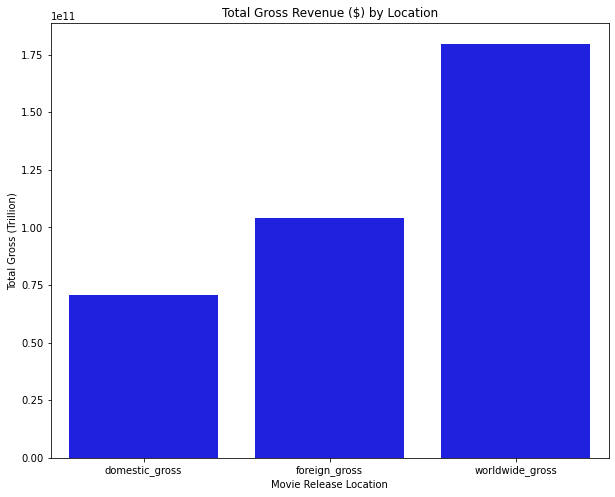

In [7]:
# convert 'foreign_gross' to float
calc_df['foreign_gross'] = pd.to_numeric(calc_df['foreign_gross'], errors='coerce')

# calculate the sums
sums = calc_df[['domestic_gross', 'foreign_gross', 'worldwide_gross']].sum()

# create a new dataframe with sums
df_sums = pd.DataFrame({'gross_type': sums.index, 'sum': sums.values})

# Now use seaborn to create the visualization
plt.figure(figsize=(10,8))
sns.barplot(x='gross_type', y='sum', data=df_sums, ci=None, color='blue')
plt.title('Total Gross Revenue ($) by Location')
plt.xlabel('Movie Release Location')
plt.ylabel('Total Gross (Trillion)')
# plt.xticks(rotation=90) # This line is commented out to display labels horizontally
plt.show();

Based on **top 10 movies (ROI)**

* The best ROI ranges from **41,560% to 3,852%** increse
* **70%** of the top ROI movies are a mix of **Horror** and **Thriller**
* **We recommend making a HORROR/THRILLER MOVIE**

In [8]:
calc_df[['title', 'roi', 'genres']].head(10)

,title,roi,genres
14420,The Gallows,41556.474000,"[horror, thriller]"
5468,The Devil Inside,10075.949000,"[thriller, horror]"
2512,Insidious,6558.059067,"[horror, thriller]"
14490,Unfriended,6336.419800,"[horror, thriller]"
235,Paranormal Activity 2,5817.067733,"[horror, thriller]"
17455,Split,5479.296120,"[horror, thriller]"
1541,Get Out,5007.359020,"[comedy, animation]"
5253,Chernobyl Diaries,4141.172100,"[horror, thriller]"
2663,Paranormal Activity 3,4040.796880,[horror]
11133,Annabelle,3851.737231,[horror]


**Visualization comparing genre AVG return on investment (ROI)**

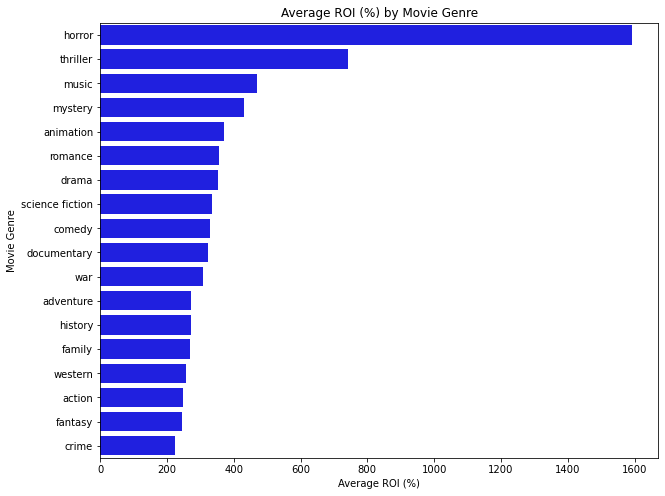

In [9]:
# assuming your dataframe is calc_df
calc_df['genres'] = calc_df['genres'].apply(lambda x: ', '.join(x)) # Joining genres into string if they are list
calc_df['genres'] = calc_df['genres'].apply(lambda x: x.split(', ')) # Splitting genres to make them list again
calc_df_exploded = calc_df.explode('genres') # This will create separate rows for each genre

# Drop rows with missing genres
calc_df_exploded = calc_df_exploded[calc_df_exploded['genres'].notna() & (calc_df_exploded['genres'] != '')]

# Now you can use groupby to find the mean 'roi' for each genre
genre_group = calc_df_exploded.groupby('genres')['roi'].mean().reset_index()

# Sorting the genres by average ROI in descending order
genre_group = genre_group.sort_values(by='roi', ascending=False)

# Now use seaborn to create the visualization
plt.figure(figsize=(10,8))
sns.barplot(x='roi', y='genres', data=genre_group, ci=None, color='blue')
plt.title('Average ROI (%) by Movie Genre')
plt.xlabel('Average ROI (%)')
plt.ylabel('Movie Genre')
plt.show()

Here are the individual genre counts across all movies for visability:

In [10]:
genre_counts = calc_df['genres'].explode().value_counts()
genre_counts

drama              342
comedy             315
action             256
thriller           220
adventure          198
family             130
science fiction    122
crime              104
fantasy            104
romance            104
horror              94
animation           82
mystery             63
history             36
music               18
war                 17
documentary         11
western              7
                     4
Name: genres, dtype: int64

**Best Month For Movie Premier (month)**

* We found the best month to launch a horror/thriller movie:
* **We recommend for your movie premier to be in October**

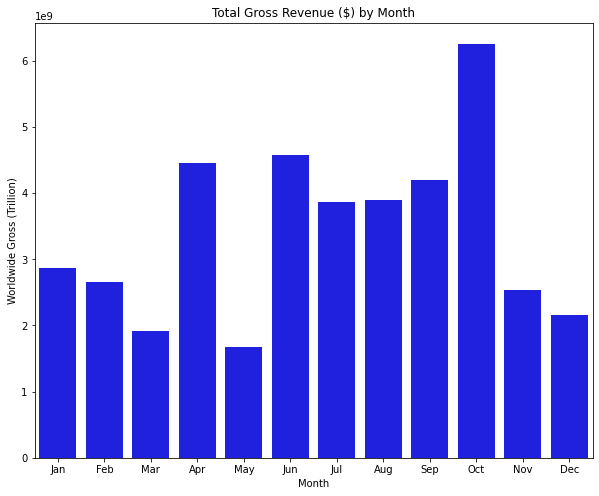

In [11]:
calc_month_df = calc_df[['genres', 'release_date', 'worldwide_gross']].copy()
calc_month_df = calc_month_df[calc_month_df['genres'].apply(lambda x: any(genre in x for genre in ['horror', 'thriller']))]
calc_month_df['release_date'] = pd.to_datetime(calc_month_df['release_date'])

grouped_calc_month_df = calc_month_df.groupby(calc_month_df['release_date'].dt.month)['worldwide_gross'].sum().reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(x=grouped_calc_month_df['release_date'], y=grouped_calc_month_df['worldwide_gross'], color='blue')
plt.xticks(range(12), [calendar.month_abbr[i] for i in range(1, 13)])
plt.title('Total Gross Revenue ($) by Month')
plt.xlabel('Month')
plt.ylabel('Worldwide Gross (Trillion)')
plt.show()

**Movie length (minutes)**

* We found that the average movie length was just over **106 mintues**.
* **We recommend keeping the movie length between 100-110 minutes**

In [12]:
# average movie length is just over 100 minutes
movie_info_df['runtime_in_minutes'].mean()

106.5228426395939

**Best DIRECTORS for the Horror/Thriller Genre**

* Based on the most profitable movies: 
* **We recommend hiring any of the below Directors in no particular order**
1. Deborah Kampmeier
2. Alexander Wraith	
3. Ariel Schulman
4. Joaquin Perea
5. John R. Leonetti	
6. Bradley Parker
7. Chris Lofing	
8. Christopher Landon
9. Gregory Plotkin
10. William Brent Bell

In [145]:
# Enter SQL Code here
q = """
SELECT *
FROM movie_basics mb
JOIN directors dr USING(movie_id)
JOIN principals pr USING(movie_id)
JOIN persons p USING(person_id)
JOIN movie_ratings mr USING(movie_id)
WHERE death_year IS NULL
AND
(
original_title LIKE '%Gallows' 
OR original_title LIKE '%Devil Inside' 
OR original_title = 'Insidious' 
OR original_title = 'Unfriended' 
OR original_title LIKE 'Paranormal Activity%' 
OR original_title = 'Split' 
OR original_title = 'Chernobyl Diaries' 
OR original_title = 'Annabelle'
)
AND 
category = 'director'
GROUP BY primary_name
;
"""
pd.read_sql(q, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,person_id,ordering,person_id,category,job,characters,primary_name,birth_year,death_year,primary_profession,averagerating,numvotes
0,tt3108988,Paranormal Activity Security Squad,Paranormal Activity Security Squad,2016,NaN,"Comedy,Horror",nm2066764,5,nm2066764,director,None,None,Alexander Wraith,1979.0,None,"actor,writer,producer",5.4,13
1,tt2109184,Paranormal Activity 4,Paranormal Activity 4,2012,88.0,"Horror,Mystery,Thriller",nm1413364,5,nm1160962,director,None,None,Ariel Schulman,NaN,None,"writer,producer,director",4.6,58408
2,tt1991245,Chernobyl Diaries,Chernobyl Diaries,2012,86.0,"Horror,Mystery,Thriller",nm0662086,5,nm0662086,director,None,None,Bradley Parker,NaN,None,"visual_effects,director,art_department",5.0,60304
3,tt2309260,The Gallows,The Gallows,2015,81.0,"Horror,Mystery,Thriller",nm3951039,5,nm4000389,director,None,None,Chris Lofing,NaN,None,"producer,director,writer",4.2,17763
4,tt2473682,Paranormal Activity: The Marked Ones,Paranormal Activity: The Marked Ones,2014,84.0,"Horror,Mystery,Thriller",nm0484907,5,nm0484907,director,None,None,Christopher Landon,1975.0,None,"writer,producer,director",5.0,37147
5,tt3315656,Split,Split,2016,127.0,"Drama,Fantasy",nm1380487,5,nm1380487,director,None,None,Deborah Kampmeier,1964.0,None,"writer,director,producer",3.6,380
6,tt2473510,Paranormal Activity: The Ghost Dimension,Paranormal Activity: The Ghost Dimension,2015,88.0,"Horror,Mystery,Thriller",nm0687427,5,nm0687427,director,None,None,Gregory Plotkin,NaN,None,"editorial_department,editor,producer",4.6,22361
7,tt2109184,Paranormal Activity 4,Paranormal Activity 4,2012,88.0,"Horror,Mystery,Thriller",nm1160962,5,nm1160962,director,None,None,Henry Joost,NaN,None,"writer,producer,director",4.6,58408
8,tt1591095,Insidious,Insidious,2010,103.0,"Horror,Mystery,Thriller",nm1490123,5,nm1490123,director,None,None,James Wan,1977.0,None,"producer,writer,director",6.9,254197
9,tt2660118,Split,Split,2016,90.0,"Comedy,Romance,Sport",nm1406121,5,nm1406121,director,None,None,Jamie Buckner,1980.0,None,"miscellaneous,production_manager,producer",2.9,557


**Best WRITERS for the Horror/Thriller Genre**

 * **We recommend choosing from any of these 15 writers**:


1. Adnan Adib Khan
2. Arijit Biswas
3. A.N. Balakrishnan
4. Seo-kyeong Jeong
5. Sarah Waters
6. Nikhil Vyas
7. Advaita Kala
8. Ramanagirivasan
9. Stephan Talty
10. Richard Phillips
11. Kanae Minato
12. Joelle Touma
13. María Belón
14. Lionel Shriver
15. Joo-Suk Park

In [144]:
# Enter SQL Code here
alive_writers = """
    SELECT 
        w.*, 
        p.primary_name, 
        ma.title,
        mb.genres,
        ma.language,
        mr.averagerating,
        mr.numvotes
    FROM writers w
    JOIN persons p ON w.person_id = p.person_id
    JOIN movie_basics mb  ON w.movie_id = mb.movie_id
    JOIN movie_akas ma ON w.movie_id = ma.movie_id
    JOIN movie_ratings mr ON w.movie_id = mr.movie_id
    WHERE p.death_year IS NULL
    AND p.primary_profession = 'writer'
    AND (mb.genres LIKE '%Horror%' OR mb.genres LIKE '%Thriller%')
    AND ma.language = 'en'
    AND mr.averagerating >= 7.5
    AND mr.numvotes > 9665
    GROUP BY primary_name
    ORDER BY mr.averagerating DESC
"""
result = pd.read_sql(alive_writers, conn)
result

,movie_id,person_id,primary_name,title,genres,language,averagerating,numvotes
0,tt5354160,nm7861818,Adnan Adib Khan,Mirror Game,"Crime,Mystery,Thriller",en,9.3,18470
1,tt8108198,nm4914249,Arijit Biswas,The Blind Melody,"Crime,Thriller",en,8.5,43409
2,tt4987556,nm5394336,A.N. Balakrishnan,The Only One,"Action,Crime,Thriller",en,8.5,13747
3,tt4016934,nm1941029,Seo-kyeong Jeong,The Handmaiden,"Drama,Romance,Thriller",en,8.1,79272
4,tt4016934,nm1258797,Sarah Waters,The Handmaiden,"Drama,Romance,Thriller",en,8.1,79272
5,tt1821480,nm4449370,Nikhil Vyas,Story,"Mystery,Thriller",en,8.1,51830
6,tt1821480,nm4298729,Advaita Kala,Story,"Mystery,Thriller",en,8.1,51830
7,tt6485666,nm8024751,Ramanagirivasan,Zapped,"Action,Thriller",en,8.0,21988
8,tt1535109,nm5643170,Stephan Talty,A Captain's Story,"Biography,Drama,Thriller",en,7.8,387402
9,tt1535109,nm3697679,Richard Phillips,A Captain's Story,"Biography,Drama,Thriller",en,7.8,387402


**Best ACTORS for the Horror/Thriller Genre**

* **Below are the top 20 actors we recommend pulling from for the horror/thriller movie**:

1. Morena Baccarin
2. Zoë Kravitz
3. Mila Kunis
4. Mackenzie Foy
5. Emily Mortimer
6. Ed Skrein
7. Richard Armitage
8. Winona Ryder
9. Henry Cavill
10. Audrey Fleurot
11. Hayley Atwell
12. Daisy Ridley
13. Jonah Hill
14. Martin Freeman
15. Natalie Portman
16. Chris Hemsworth
17. Jennifer Lawrence
18. Scarlett Johansson
19. Gwyneth Paltrow
20. Leonardo DiCaprio


In [ ]:
# Enter SQL Code here
q = """
SELECT principals.movie_id, principals.person_id, principals.category, principals.characters, 
    persons.primary_name, persons.birth_year, persons.death_year, movie_basics.primary_title, 
    movie_basics.genres, movie_ratings.averagerating, movie_ratings.numvotes
FROM principals
JOIN persons USING(person_id)
JOIN movie_basics USING(movie_id)
JOIN movie_ratings USING(movie_id)
WHERE principals.category LIKE '%act%' 
    AND persons.birth_year >= 1968
    AND persons.death_year IS NULL
GROUP BY primary_name
ORDER BY movie_ratings.numvotes DESC

LIMIT 20
;
"""
pd.read_sql(q, conn)

# **Linear Regression**

## Creating dataframe for linear regression analysis. Importing so many columns for EDA prior to the regression analysis


In [13]:
calc_reg_df = calc_df[['genres', 'release_date', 'vote_count', 'popularity', 'domestic_gross', 'foreign_gross', 'worldwide_gross', 'production_budget',
                       'net_profit', 'roi']].copy()
calc_reg_df = calc_reg_df[calc_reg_df['genres'].apply(lambda x: any(genre in x for genre in ['horror', 'thriller']))]

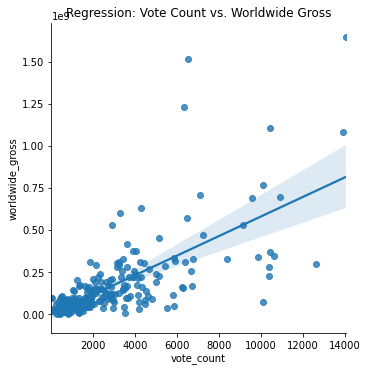

In [17]:
sns.lmplot(x='vote_count', y='worldwide_gross', data=calc_reg_df)
plt.title("Regression: Vote Count vs. Worldwide Gross")
plt.show()

In [15]:
X = calc_reg_df['vote_count'] # Independent variable
y = calc_reg_df['worldwide_gross'] # Dependent variable
X = sm.add_constant(X)

In [16]:
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     253.7
Date:                Thu, 22 Jun 2023   Prob (F-statistic):           3.31e-40
Time:                        10:20:17   Log-Likelihood:                -5246.3
No. Observations:                 259   AIC:                         1.050e+04
Df Residuals:                     257   BIC:                         1.050e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.499e+06   1.37e+07      0.110      0.9